### 11.0 Model Evaluation and Training
> Here I perform the following tasks:
>> - __1)__ Evaluate the performance of different algorithms with KFold cross-validation, to determine which is best at modeling un-seen data.
>> - __2)__ After selecting an algorithm I perform a feature importance analysis to remove features that are not adding any value.
>> - __3)__ Peform a grid search to find the optimal parameters for the final algorithm.
>> - __4)__ Train the final model.
>> - __5)__ Prepare a home credit competition submission file.


In [24]:
import warnings
warnings.filterwarnings("ignore")

def fxn():
    warnings.warn("userwarning", UserWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
#import helper ultility module
%load_ext autoreload
%aimport utils
%autoreload 1

In [3]:
#ml algorithms
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold 
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV

#nerual networks api
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras import optimizers
import tensorflow as tf

import seaborn as sns
sns.set(style="whitegrid")
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### 11.1 Import Normalized Dataset
> - Here we import the training that has already been normalized.

In [4]:
dataset = utils.get_stratified_train_norm()

In [5]:
dataset.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,NAME_HOUSING_TYPE_MAP_2,NAME_HOUSING_TYPE_MAP_3,NAME_HOUSING_TYPE_MAP_4,NAME_HOUSING_TYPE_MAP_5,INSTLL_PAY_PAYMENT_GRADE_MAP_0,INSTLL_PAY_PAYMENT_GRADE_MAP_1,INSTLL_PAY_PAYMENT_GRADE_MAP_2,INSTLL_PAY_PAYMENT_GRADE_MAP_3,INSTLL_PAY_PAYMENT_GRADE_MAP_4,INSTLL_PAY_PAYMENT_GRADE_MAP_5
0,121145,0.0,-1.173912,-0.704145,-0.526060,-1.124961,-1.710078,0.849127,1.899305,-1.304187,...,0,0,0,0,1,0,0,0,0,0
1,446181,0.0,-1.059658,-0.266871,0.551123,-0.007245,0.524463,0.296552,-1.045096,0.752533,...,0,0,0,0,0,0,0,1,0,0
2,378637,0.0,-0.562612,-0.115158,0.728248,1.167251,-1.329080,0.468171,1.194630,1.029703,...,0,0,0,0,1,0,0,0,0,0
3,402605,0.0,-0.156496,0.548233,0.395341,-0.063101,-1.554110,0.849127,1.760794,-0.691253,...,0,0,0,0,0,1,0,0,0,0
4,156160,0.0,-1.700458,-1.402146,-1.839272,-0.971920,1.401176,-0.111749,-0.543886,0.636003,...,0,0,0,0,1,0,0,0,0,0


### 11.2 Evaluate Models Performance
> Here I evaluate the performance of different algorithms with KFold cross-validation, to determine which is best at modeling the data. Cross validation is a re-sampling technique that gives an indication how well an algorithm will perform on unseen data.

> The following are the algorithms I evaluated:
>> - 1) Naive Predictor:  
>>> The naive predictor is a benchmark model that will always predict that a loan will always get repaid. This model shows what a model without any intelligence would look like. 
>> - 2) [Logistic Regression Classifer](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html): 
>>> Used for binary classification problems with two class values (binary values). It is used to explain the relationship between one dependent binary variable and one or more independent variables.  
>> - 3) [Gradient Boosting Classifer](https://en.wikipedia.org/wiki/Gradient_boosting):
>>> A machine learning ensemble method that produces a strong model by combining weak models. It’s used on both classifications and regression problems. I will test three different implentations of Gradient Boosting([LXGB](https://lightgbm.readthedocs.io/en/latest/Python-API.html), [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and [XGBoost](https://xgboost.readthedocs.io/en/latest/)).
>> - 4) [Linear Discriminant Analysis (LDA)](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html): 
>>> A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
>> - 5) [Gaussian Naive Bayes (NB)](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html):
>>> An implementation of the Gaussian Naive Bayes algorithm for classification where the likelihood of the features is assumed to be Gaussian.
>> - 6) Two layer [Neural Network](https://en.wikipedia.org/wiki/Artificial_neural_network) implented in [keras](https://keras.io/):
>>> A neural network is a type of algorithm which models itself after the human brain. A neural network algorithm automates the process of learning patterns from data to then make predictions new data<sup>[1](https://www.techradar.com/news/what-is-a-neural-network)</sup>.

### 11.2(a) Define Naive Predictor and Neural Network
> For convience I define a Native Predictor and an Neural Network class that has the same interface as the other algorithms.

In [14]:
class NaivePredictor(BaseEstimator):
    """ Naive predictor is a benchmark 
        model that will always predict that a loan
        will always get repaid.
    """
    
    def fit(self,X,y):
        """Do nothing"""
        pass
    
    def predict(self,X):
        """ Always predict 0 for loan repayment."""
        return np.zeros(X.shape[0])
    
    def predict_proba(self,X): 
        """ Return probability 100% for loan repayment."""
        prob = np.zeros((X.shape[0],2))
        
        #predict 100% loan repayment
        prob[:,0]=1
        
        return prob

In [7]:
# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
#     value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)
    value, update_op = tf.metrics.auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

class NeuralNetwork(BaseEstimator):
    """ Two layer neural network.
    """
    def __init__(self,input_shape=None,epochs=15,batch_size=250, optimizer='adagrad', init='normal'):
        
        self.optimizer = optimizer
        self.init = init
        self.batch_size = batch_size
        self.epochs = epochs
        self.input_shape=input_shape
        
        self.model_ = Sequential()
        self.model_.add(Dense(300, input_dim=input_shape ,kernel_initializer=self.init ,  activation='relu'))
        self.model_.add(Dense(1,kernel_initializer=self.init ,activation='sigmoid'))
        self.model_.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=[ auc_roc])
    
    def fit(self,X,y,valid_set=None):
        """Fit model"""
        
        if valid_set is None:
            return self.model_.fit(X,y, epochs=self.epochs,verbose=0,  validation_split=0.1, batch_size =self.batch_size)
        else:
            return self.model_.fit(X,y, epochs=self.epochs,verbose=0,  validation_data=valid_set , batch_size =self.batch_size)
    
    def predict(self,X, y=None):
        """ Always predict 0 for loan repayment."""
        probs = np.zeros((X.shape[0],2) )
        probs[:,1] = self.model_.predict(X).flatten()
        probs[:,0] = 1 - probs[:,1]
        
        return np.argmax(probs, axis=1)
    
    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X))) 
    
    def predict_proba(self,X): 
        """ Return probability ."""
        probs = np.zeros((X.shape[0],2) )
        probs[:,1] = self.model_.predict(X).flatten()
        probs[:,0] = 1 - probs[:,1]
        
        return probs

### 11.2(b) Perform Model Evaluations
> Test each model using stratified k-Fold cross-validation.

#### Evaluation Summary:
The best peforming algorithm is the LGBM Gradient Boosting algorithm.  It achived the highest mean score, had a low standard deviation between folds and was one of the fastest. 

In [8]:
def evaluate_models(models,X_,y_,fold_split=10):
    """ Evaluates the performance of given models."""
    results = []
    names = []
    scoring = 'roc_auc'
    for count, (name, model) in enumerate(models):
        start = time.time()
        kfold = StratifiedKFold(n_splits=fold_split, random_state=54)
        cv_results = cross_val_score(model, X_, y_, cv=kfold, scoring=scoring)
        end = time.time()
        results.append(cv_results)
        names.append(name)
        time_elapsed = time.strftime("%H:%M:%S", time.gmtime(time.time() - start))
        msg = " {}) Model: {} Mean: {:.4f} Std: {:.4f} Elapsed Time: {}"
        print(msg.format(count+1 ,name, cv_results.mean(), cv_results.std(),time_elapsed))
        
    #return dataframe of results
    names_rows = []
    results_rows = []
    for n,arr in zip(names,results):
        for a in arr:
            names_rows.append(n)
            results_rows.append(a)
    return pd.DataFrame({'Model':names_rows,'Score':results_rows})


In [9]:
#create features and target for model evaluation
X = dataset.drop(['SK_ID_CURR','TARGET'],axis=1).values
y = dataset['TARGET'].values

print("Features shape {}. Target shape {}".format(X.shape,y.shape))

Features shape (48765, 281). Target shape (48765,)


 1) Model: Naive Predcitor Mean: 0.5000 Std: 0.0000 Elapsed Time: 00:00:04
 2) Model: LDA Mean: 0.7725 Std: 0.0033 Elapsed Time: 00:00:25
 3) Model: Logistic Regression Mean: 0.7727 Std: 0.0034 Elapsed Time: 00:01:07
 4) Model: NB Mean: 0.6694 Std: 0.0050 Elapsed Time: 00:00:05
 5) Model: LGBM Mean: 0.7755 Std: 0.0034 Elapsed Time: 00:01:16
 6) Model: XGB Mean: 0.7702 Std: 0.0040 Elapsed Time: 00:10:44
 7) Model: Gradient Boosting Mean: 0.7703 Std: 0.0040 Elapsed Time: 00:18:00
 8) Model: Neural Network Mean: 0.7679 Std: 0.0028 Elapsed Time: 00:02:20


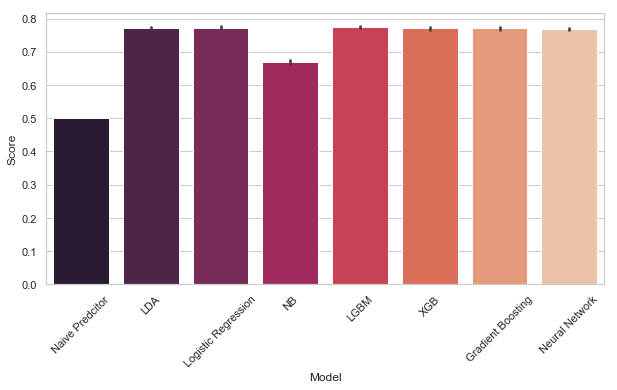

In [25]:
#let evaluate all the models 
seed = 54
models = []

models.append(('Naive Predcitor', NaivePredictor() ))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('Logistic Regression', LogisticRegression(solver='lbfgs',max_iter=500 )))
models.append(('NB', GaussianNB()))

# # different implentations of gradiant boosting
models.append(('LGBM', LGBMClassifier(random_state = seed) ))
models.append(('XGB', xgb.XGBClassifier(random_state = seed)))
models.append(('Gradient Boosting', GradientBoostingClassifier(random_state=seed)))

# #neural network
models.append(('Neural Network', NeuralNetwork(input_shape=X.shape[1],init='truncated_normal') ) )

results_df = evaluate_models(models,X,y,5)

f,ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="Model", y="Score", palette="rocket",data=results_df, ci="sd")

#rotate x axis
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

plt.show()

### 11.3 Feature Importance
> - Lets selected the most important features.

In [10]:
def get_feature_importance(df):
    
    #columns to drop
    drop_cols = []
    
    cycle = 1
    while True:
        
        if len(drop_cols)>0:
            X_df = df.drop(['SK_ID_CURR','TARGET'] + drop_cols,axis=1)
            X = X_df.values
        else:
            X_df = df.drop(['SK_ID_CURR','TARGET'],axis=1)
            X = X_df.values
            
        y = df['TARGET'].values

        # split into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=54,stratify=y)

        model = LGBMClassifier(random_state = 54)
        model.fit(X_train, y_train, eval_metric= 'auc', 
                eval_set=[(X_test, y_test)], verbose=0)

        # predict probabilities for the positive outcome only
        probs = model.predict_proba(X_test)[:, 1]

        # calculate AUC
        auc = roc_auc_score(y_test, probs)
        print("Cycle: {}".format(cycle))
        print("-" * 25)
        print("AUC: {:.4f}".format(auc)) 
        
        #get column namees and important features vector
        col_name =  X_df.columns.values
        importances = model.feature_importances_

        # print("Column name len {}".format(len(col_name)))
        print("Important features length {}".format(len(importances)))

        imp_df = pd.DataFrame({'Feature':col_name,  'Importance':importances}) 

        imp_df.sort_values(by='Importance', ascending=False,inplace=True)
        
        #get featues with no value
        no_value = imp_df[imp_df['Importance'] == 0.0]['Feature'].values.tolist()
        
        print("No value feature count {}".format(len(no_value)))
        print(("-" * 25) + "\n")
        
        if len(no_value) > 0:
            for c in no_value:
                drop_cols.append(c)
            
            cycle += 1
        else:
            #return features that add value
            return imp_df[imp_df['Importance'] > 0.0].reset_index(drop=True)
            

In [11]:
importance_df = get_feature_importance(dataset)
importance_df.head(20)

Cycle: 1
-------------------------
AUC: 0.7805
Important features length 281
No value feature count 63
-------------------------

Cycle: 2
-------------------------
AUC: 0.7805
Important features length 218
No value feature count 0
-------------------------



,Feature,Importance
0,EXT_SOURCE_2,144
1,EXT_SOURCE_1,136
2,EXT_SOURCE_3,116
3,CREDIT_TERM,115
4,AMT_ANNUITY,77
5,DAYS_BIRTH,75
6,TIMELY_PERCENT,66
7,POS_BAL_CNT_INSTALMENT_FUTURE_MEAN,54
8,POS_BAL_MONTHS_BALANCE_STD,52
9,DAYS_ID_PUBLISH,51


### 11.4 Create Training And Testing Dataset
> - Lets split the data into a training and a testing set using stratification.

In [12]:
#only select the important features
X_imp = dataset[importance_df['Feature'].values].values
y_imp = dataset['TARGET'].values

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.1, random_state=54,stratify=y_imp)
print("X training size: {} and y training size {}:".format(X_train.shape,y_train.shape))
print("X testing size: {} and y testing size {}:".format(X_test.shape,y_test.shape))

X training size: (43888, 218) and y training size (43888,):
X testing size: (4877, 218) and y testing size (4877,):


### 11.5 LGBM Tunning
> I peformed a grid search to find the optimal parameters for the following parameters:
>> - 1) `num_leaves` - (int, optional (default=31)) – Maximum tree leaves for base learners.
>> - 2) `max_depth` - (int, optional (default=-1)) – Maximum tree depth for base learners, -1 means no limit.
>> - 3) `learning_rate` - (float, optional (default=0.1)) – Boosting learning rate.
>> - 4) `n_estimators` - (int, optional (default=100)) – Number of boosted trees to fit.

> I choose these parameters based on the recomendation from the [API documents](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html).

In [18]:
#define a function to perform a grid search on the LGBM model
def gridSearchLGBM(grid_Params):
    """Perform grid search on LGBM"""
    
    mdl = LGBMClassifier(random_state=54)
    # Create the grid
    kfold = StratifiedKFold(n_splits=5, random_state=54)
    scoring = {'AUC': 'roc_auc'}
    grid = GridSearchCV(mdl, grid_Params,verbose=0,cv=kfold,scoring = scoring , n_jobs=-1, refit='AUC')

    # Run the grid
    grid.fit(X_train, y_train ,verbose=0, 
                eval_set=[(X_test, y_test)], 
                eval_metric= 'auc')

    # Print the best parameters found
    print(grid.best_params_)
    print(grid.best_score_)

In [20]:
# Create parameters to search for num_leaves and max_depth
gridParams = {
    'num_leaves': [20,25,31,35],
    'max_depth': [15,20,25,30]
    }

gridSearchLGBM(gridParams)

{'max_depth': 20, 'num_leaves': 25}
0.7746028982673459


In [21]:
# Create parameters to search for learning rate and estimators
gridParams = {
    'learning_rate': [0.08,0.09,0.1],
    'n_estimators': [100,200,300,400],
    'num_leaves': [25],
    'max_depth': [20]
    }

gridSearchLGBM(gridParams)

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 25}
0.7746028982673459


### 11.6 Train Final Model
> Train the final model compare it to the naive predictor.

LGBM AUC: 0.7816
Bench AUC: 0.5000


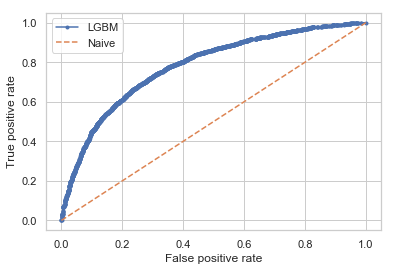

In [20]:
final_model = LGBMClassifier(learning_rate= 0.1,
                             max_depth= 20,
                             n_estimators= 100,
                             num_leaves= 25,
                             random_state = 54)

final_model.fit(X_train, y_train ,verbose=0, 
                eval_set=[(X_test, y_test)], 
                eval_metric= 'auc')


#define bench mark model and train it
bench = NaivePredictor()
bench.fit(X_train, y_train )

# predict probabilities
# keep probabilities for the positive outcome only
probs_bench = bench.predict_proba(X_test)[:,1]
probs = final_model.predict_proba(X_test)[:, 1]

# calculate AUC
auc_bench = roc_auc_score(y_test, probs_bench)
auc = roc_auc_score(y_test, probs)
print('LGBM AUC: {:.4f}'.format(auc))
print('Bench AUC: {:.4f}'.format(auc_bench))

# calculate roc curve
fpr_bench, tpr_bench, thresholds_bench  = roc_curve(y_test, probs_bench)
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='LGBM')

plt.plot(fpr_bench, tpr_bench,linestyle='--',label='Naive')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate') 

# show the plot
plt.legend()
plt.show()

### 11.7 Prepare Kaggle Submission File

In [21]:
sub_dataset = utils.get_stratified_test_norm()
print("Submission dataset shape {}".format(sub_dataset.shape)) 

Submission dataset shape (48744, 282)


In [22]:
#make prediction and update dataset
submit_X = sub_dataset[importance_df['Feature'].values].values
submit_X_ids = sub_dataset.index.values

sub_dataset['TARGET'] = 0.0

predict = final_model.predict_proba(submit_X)[:, 1]
print("Predict shape {}".format(predict.shape))

target_update = pd.DataFrame(predict.flatten(), columns=['TARGET'], index=submit_X_ids)
sub_dataset.update(target_update)
sub_dataset[['SK_ID_CURR','TARGET']].head()

Predict shape (48744,)


,SK_ID_CURR,TARGET
0,100001,0.284373
1,100005,0.689013
2,100013,0.185672
3,100028,0.356013
4,100038,0.648593


In [23]:
sub_dataset[['SK_ID_CURR','TARGET']].to_csv('submission.csv',index=False)